## Setup

In [23]:
%load_ext autoreload
%autoreload 2

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


In [24]:
import sys, os

ROOT_PATH = os.path.abspath(os.path.join("..", ".."))
SRC_PATH = os.path.join(ROOT_PATH, "flaresight")
sys.path.insert(0, SRC_PATH)
print(sys.path)

['c:\\Users\\benja\\Documents\\miru\\flaresight\\flaresight', 'c:\\Users\\benja\\Documents\\miru\\flaresight\\flaresight', 'c:\\Users\\benja\\Documents\\miru\\flaresight\\flaresight', 'c:\\Users\\benja\\Documents\\miru\\flaresight\\sample_usage\\train', 'C:\\Users\\benja\\AppData\\Local\\Programs\\Python\\Python311\\python311.zip', 'C:\\Users\\benja\\AppData\\Local\\Programs\\Python\\Python311\\DLLs', 'C:\\Users\\benja\\AppData\\Local\\Programs\\Python\\Python311\\Lib', 'C:\\Users\\benja\\AppData\\Local\\Programs\\Python\\Python311', 'c:\\Users\\benja\\Documents\\miru\\flaresight\\env', '', 'c:\\Users\\benja\\Documents\\miru\\flaresight\\env\\Lib\\site-packages', 'c:\\Users\\benja\\Documents\\miru\\flaresight\\env\\Lib\\site-packages\\win32', 'c:\\Users\\benja\\Documents\\miru\\flaresight\\env\\Lib\\site-packages\\win32\\lib', 'c:\\Users\\benja\\Documents\\miru\\flaresight\\env\\Lib\\site-packages\\Pythonwin']


In [25]:
DOWNLOADS_PATH = os.path.join(os.path.expanduser("~"), "downloads")
SENSOR_DATA_PATH = os.path.join(ROOT_PATH, "sensor_data")

In [36]:
import random

# local imports
from filesys.dir import Dir
from filesys.file import File
from data.detection import *
import train

# 3rd party imports
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
from scipy import stats
from sklearn.linear_model import LogisticRegression
from sklearn.model_selection import train_test_split, cross_val_score
from sklearn.metrics import roc_auc_score

## Explore Data

In [27]:
SMOKE_DETECTION_PATH = os.path.join(SENSOR_DATA_PATH, "smoke_detection_iot", "data.csv")
df = pd.read_csv(SMOKE_DETECTION_PATH)
print("Number of Samples: ", df.shape[0])
df.head()

Number of Samples:  62630


,Unnamed: 0,UTC,Temperature[C],Humidity[%],TVOC[ppb],eCO2[ppm],Raw H2,Raw Ethanol,Pressure[hPa],PM1.0,PM2.5,NC0.5,NC1.0,NC2.5,CNT,Fire Alarm
0,0,1654733331,20.000,57.36,0,400,12306,18520,939.735,0.0,0.0,0.0,0.0,0.0,0,0
1,1,1654733332,20.015,56.67,0,400,12345,18651,939.744,0.0,0.0,0.0,0.0,0.0,1,0
2,2,1654733333,20.029,55.96,0,400,12374,18764,939.738,0.0,0.0,0.0,0.0,0.0,2,0
3,3,1654733334,20.044,55.28,0,400,12390,18849,939.736,0.0,0.0,0.0,0.0,0.0,3,0
4,4,1654733335,20.059,54.69,0,400,12403,18921,939.744,0.0,0.0,0.0,0.0,0.0,4,0


In [28]:
train, test = train_test_split(df, test_size=0.2, random_state=42)
X_train = train.iloc[:, 2:-1]; y_train = train["Fire Alarm"]
X_test = test.iloc[:, 2:-1]; y_test = test["Fire Alarm"]
print("Training Samples: ", X_train.shape[0])
print("Testing Samples: ", X_test.shape[0])
X_train.head()

Training Samples:  50104
Testing Samples:  12526


,Temperature[C],Humidity[%],TVOC[ppb],eCO2[ppm],Raw H2,Raw Ethanol,Pressure[hPa],PM1.0,PM2.5,NC0.5,NC1.0,NC2.5,CNT
28479,21.430,59.72,283,400,13138,19923,939.672,1.38,1.43,9.48,1.478,0.033,3485
42605,25.980,47.24,1247,422,12886,19423,938.734,1.73,1.79,11.88,1.853,0.042,17611
17963,18.116,47.55,1124,400,12909,19446,938.710,1.56,1.62,10.75,1.677,0.038,17963
56394,59.620,11.60,60000,4305,11771,17216,936.746,1382.21,1624.71,9039.26,1709.083,216.618,5252
29875,22.250,48.83,24,400,13255,20202,939.700,2.25,2.33,15.47,2.412,0.054,4881


### Fire / No Fire Distribution

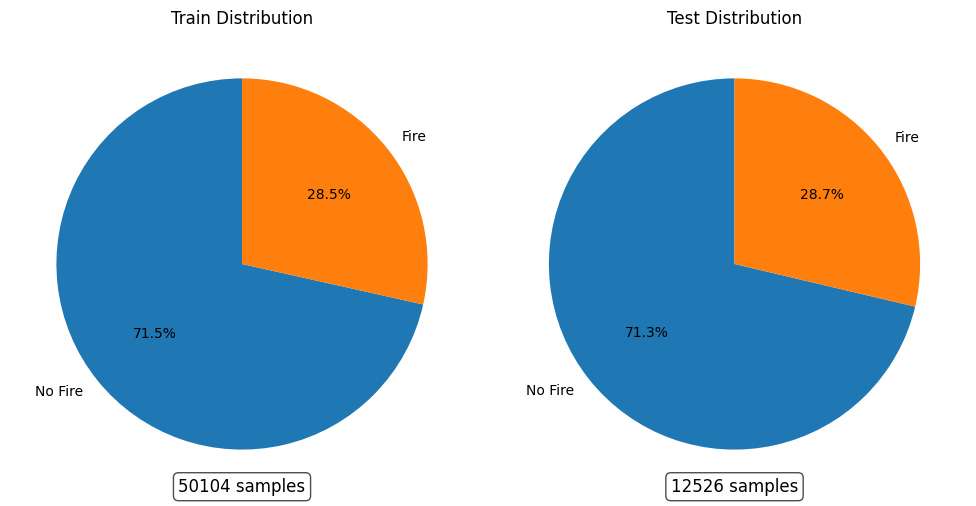

In [29]:
plot_label_distribution(y_train, y_test)

### Feature Scatterplots

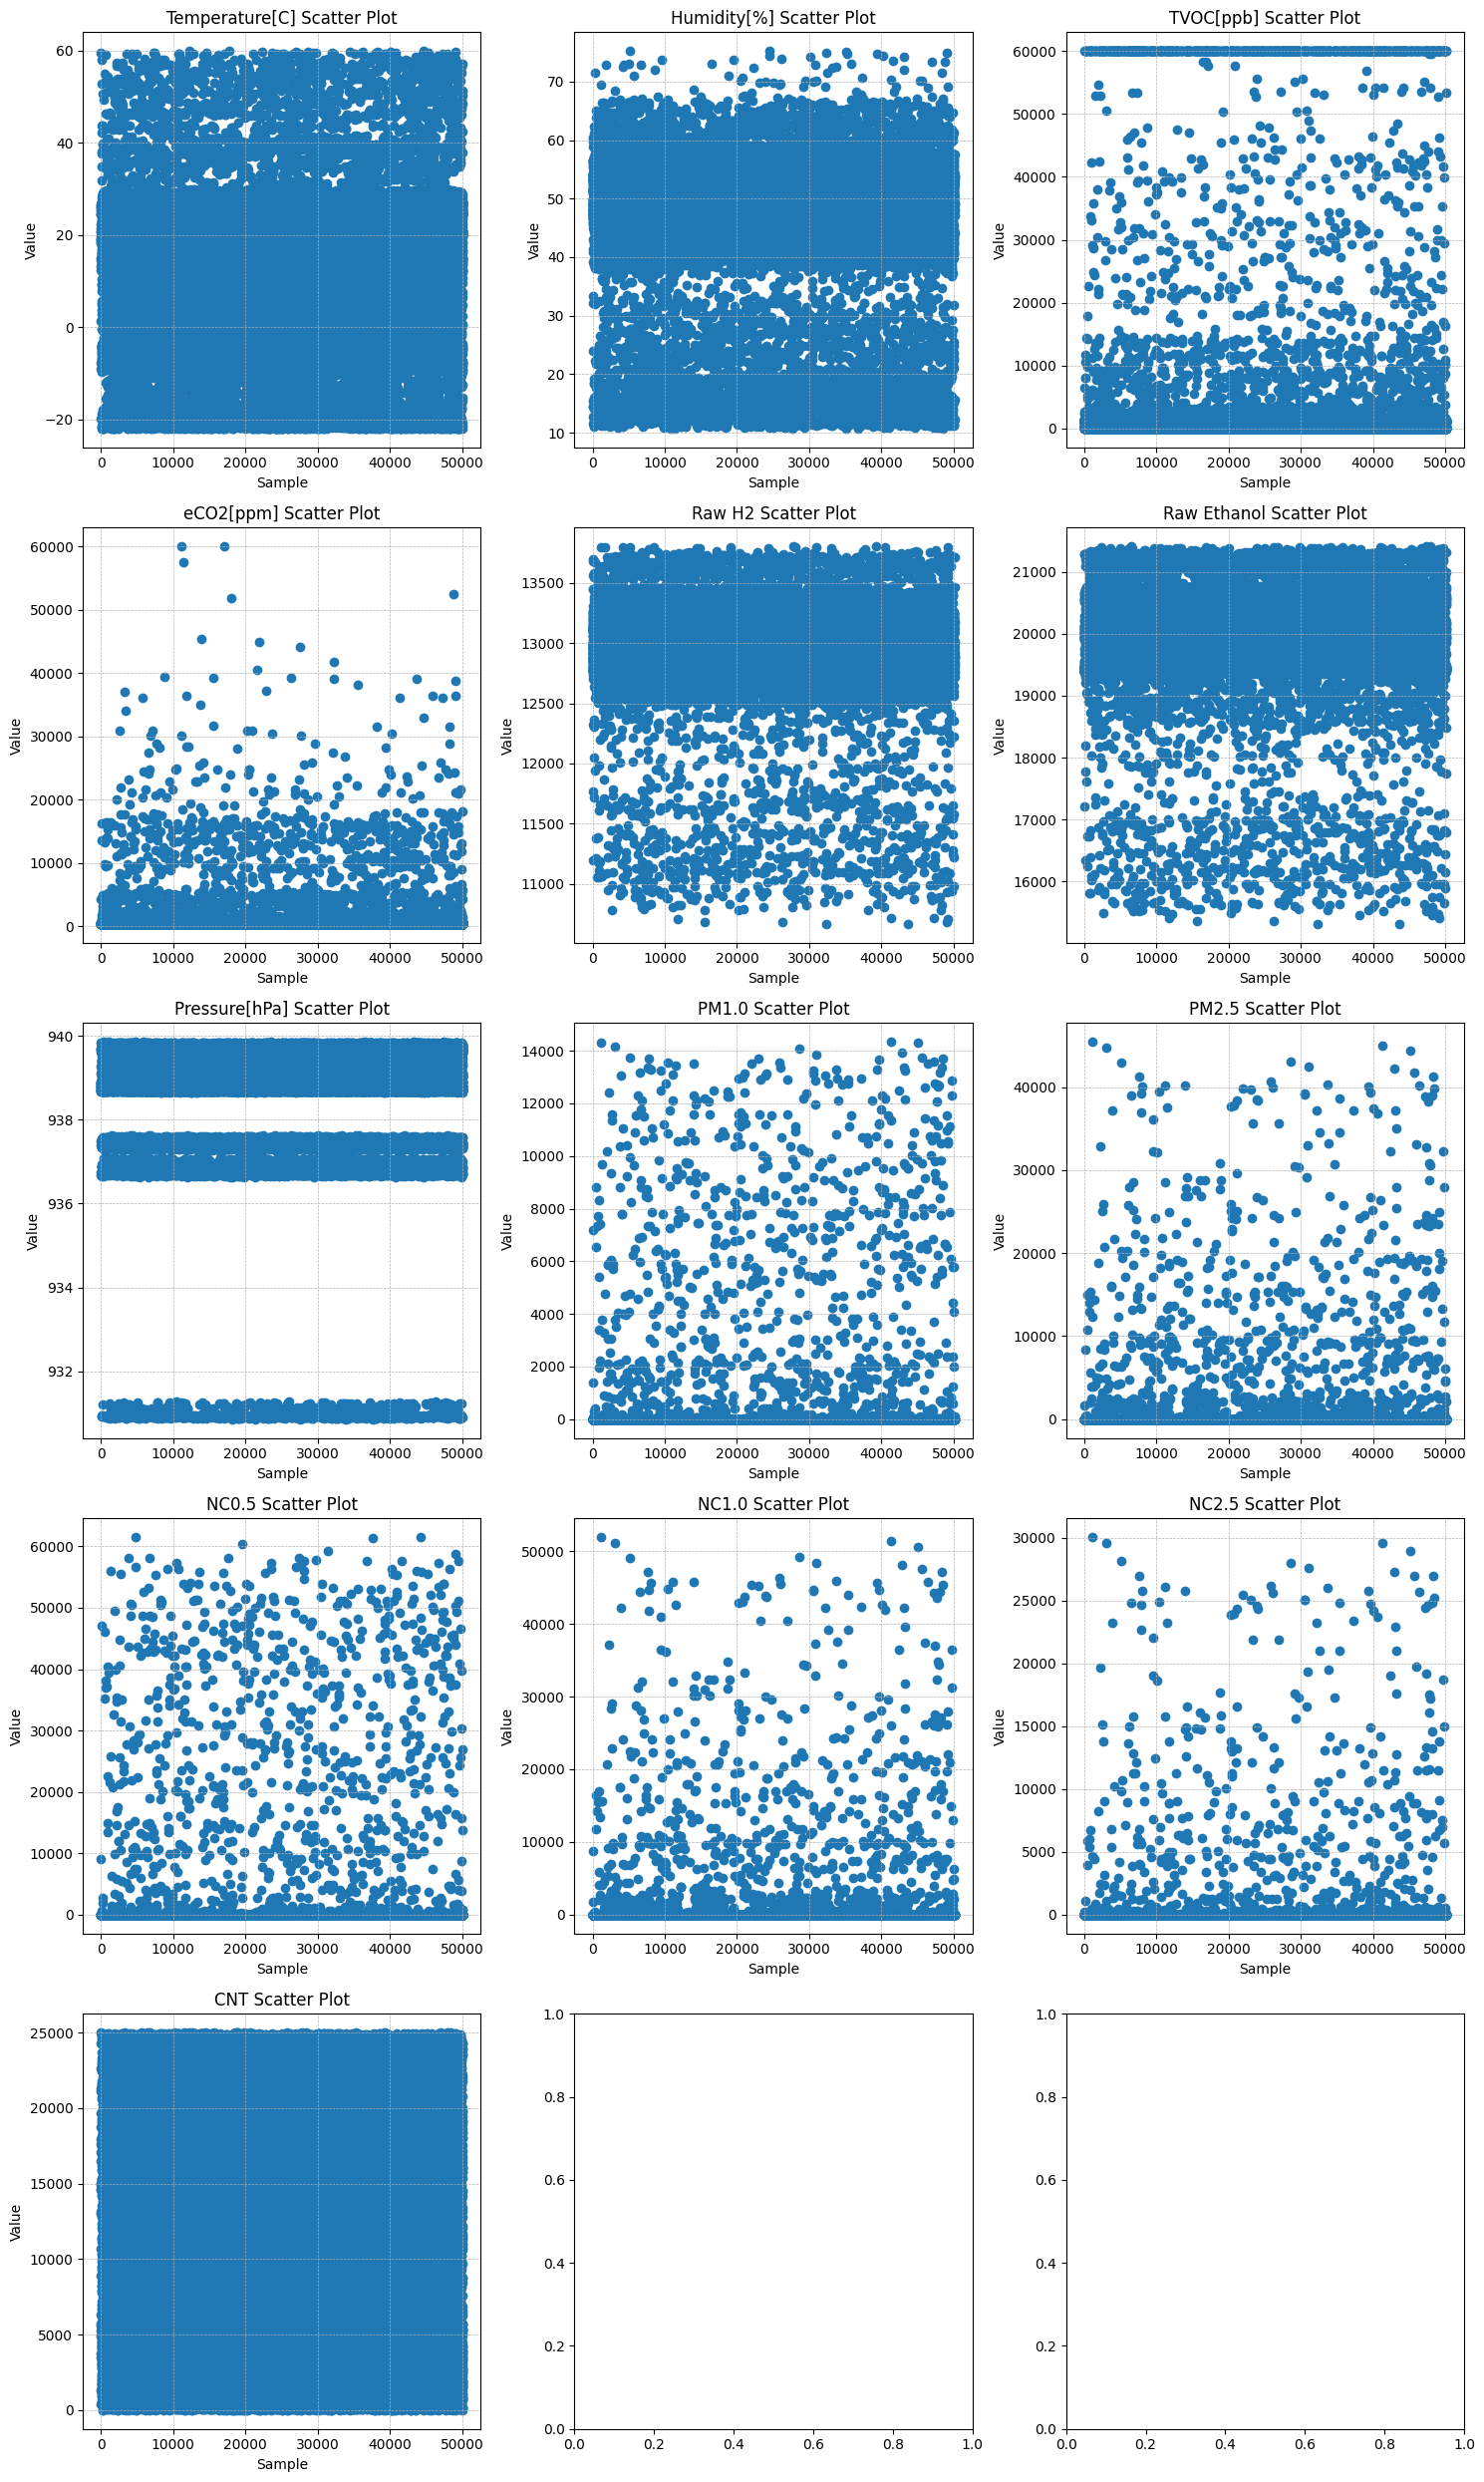

In [30]:
plot_feature_scatterplots(X_train, n_cols=3)

### Feature Cross-Correlations

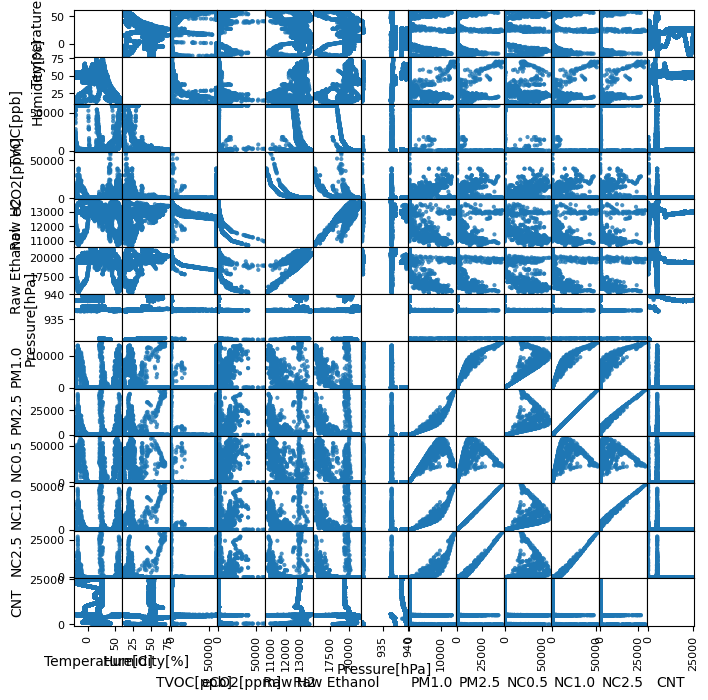

In [19]:
pd.plotting.scatter_matrix(
    X_train, alpha = 0.8, figsize=(8, 8), diagonal='scatter'
)
print()

### Feature vs. Fire / No Fire Correlations

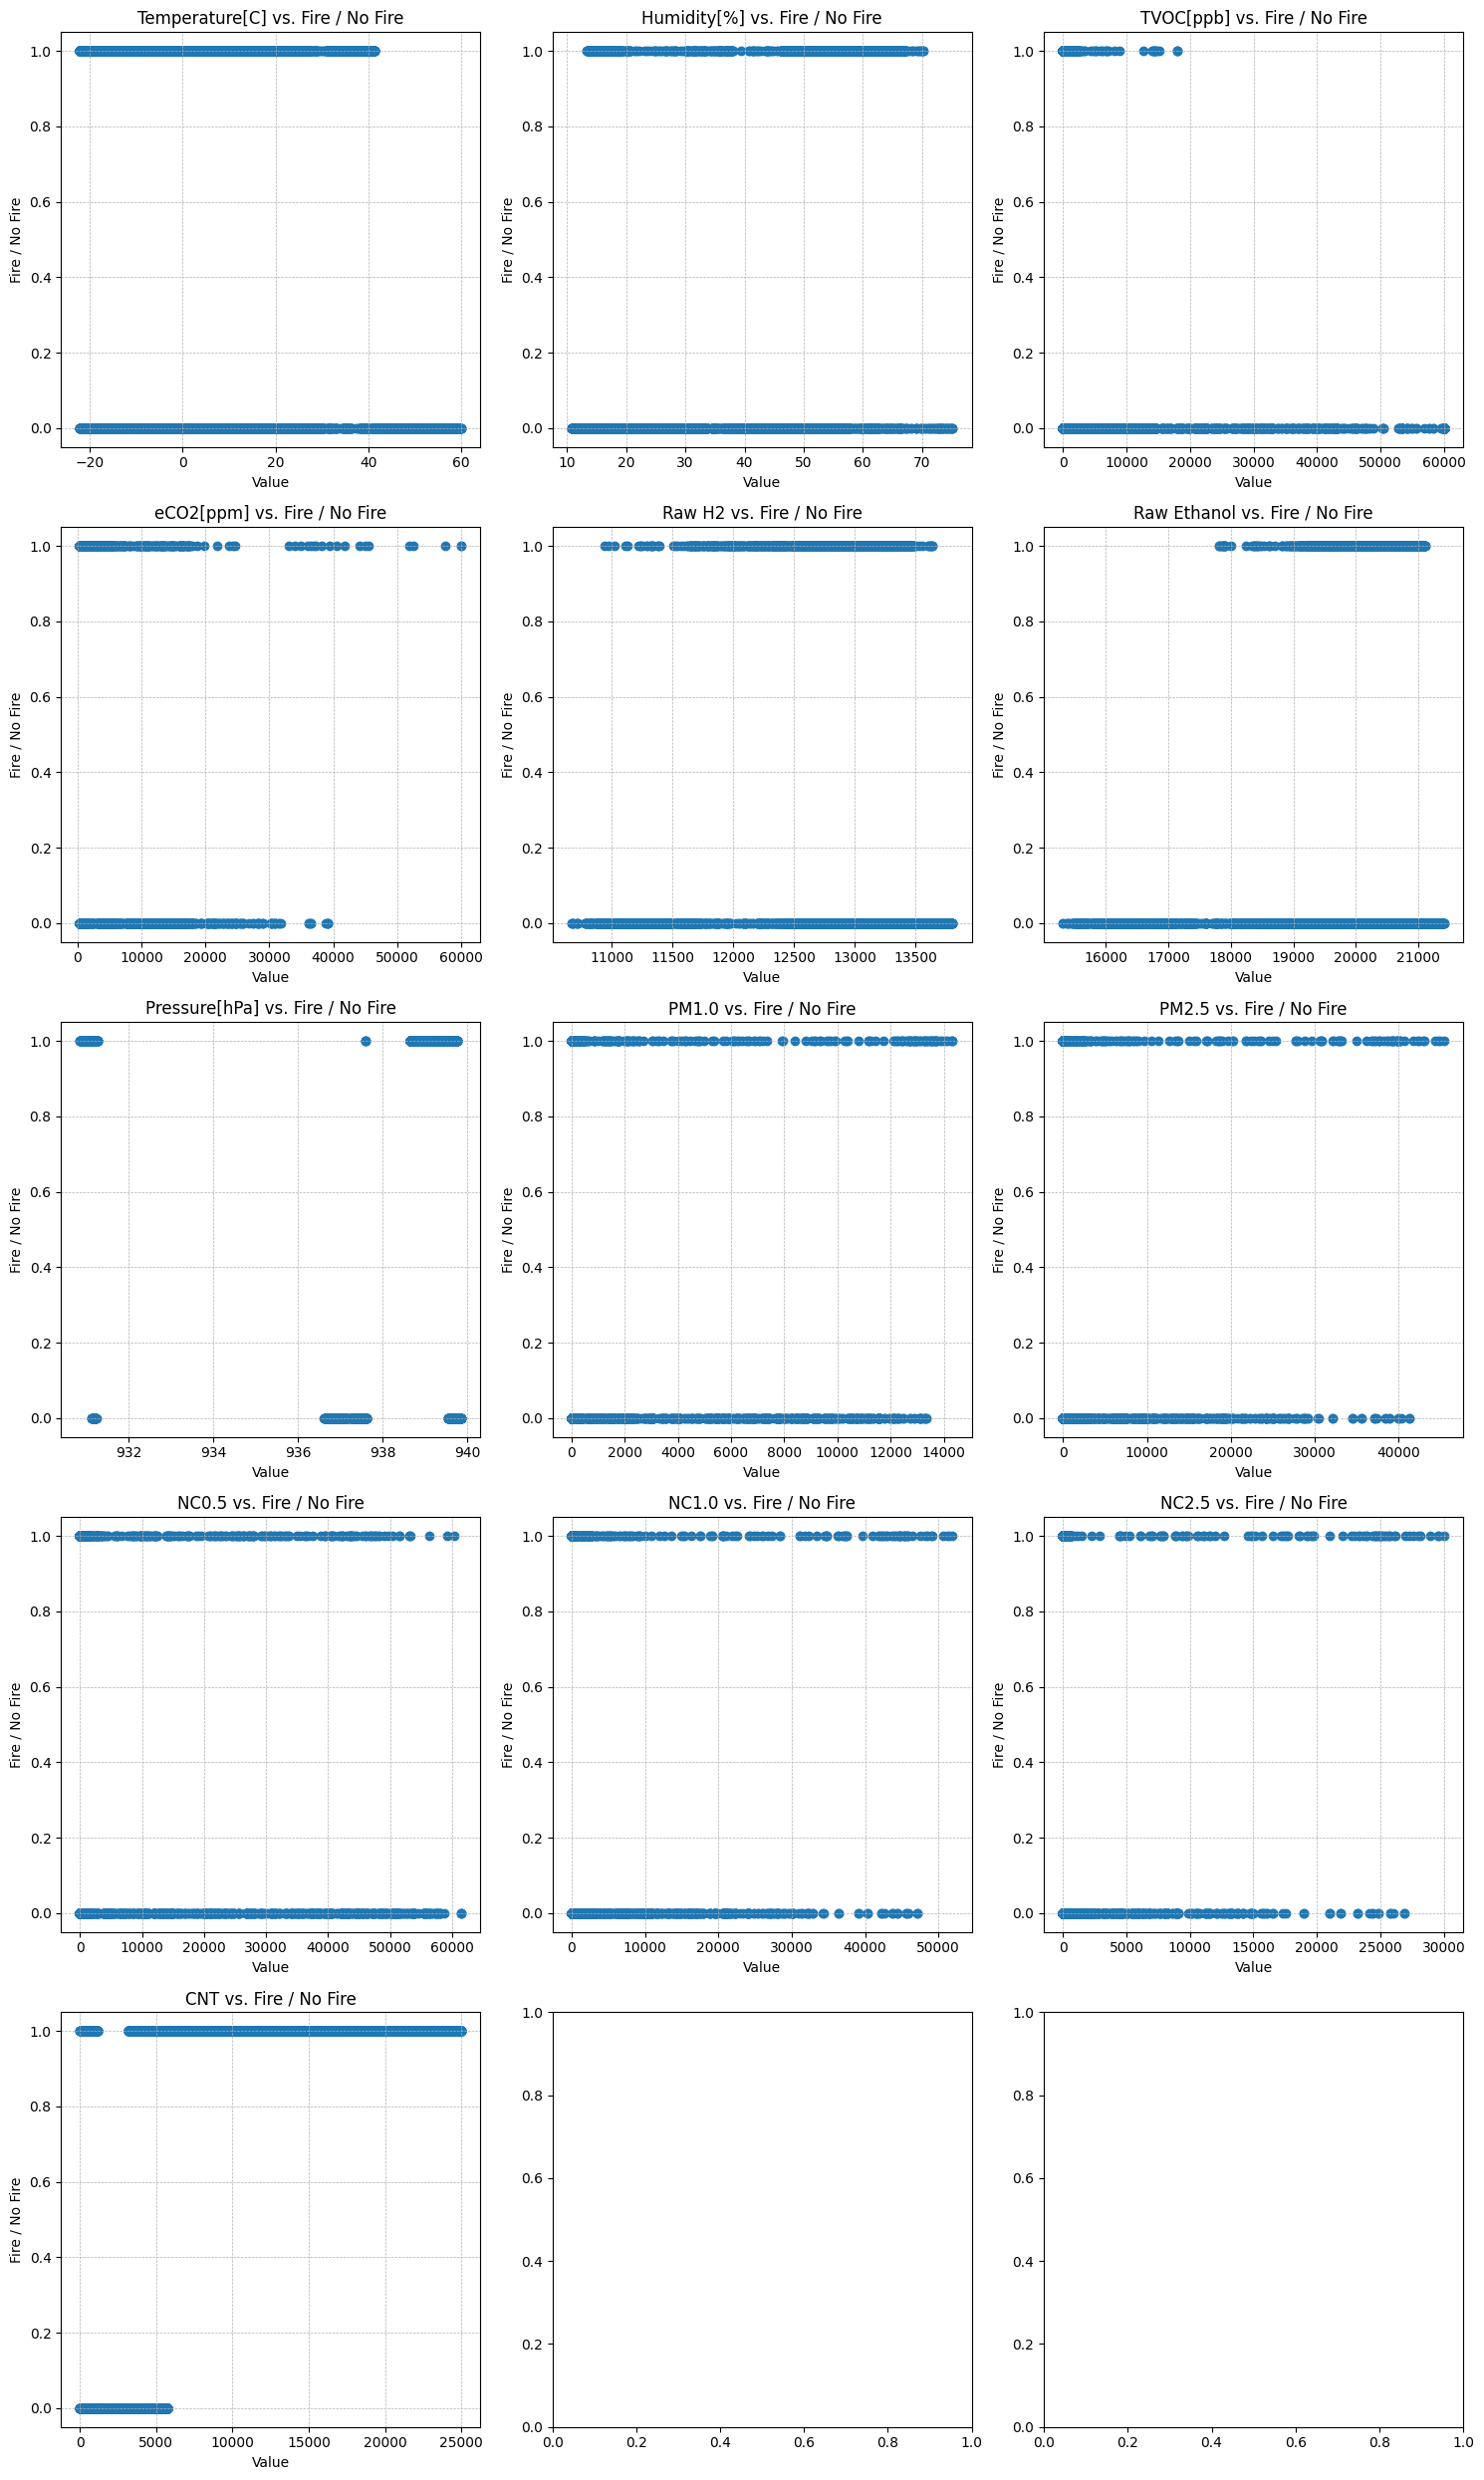

In [31]:
plot_feature_vs_fire(X_train, y_train, n_cols=3)

## Cleaning and Feature Engineering

In [32]:
X_train = standardize_df(X_train)
X_test = standardize_df(X_test)

### sanity check plots look similar

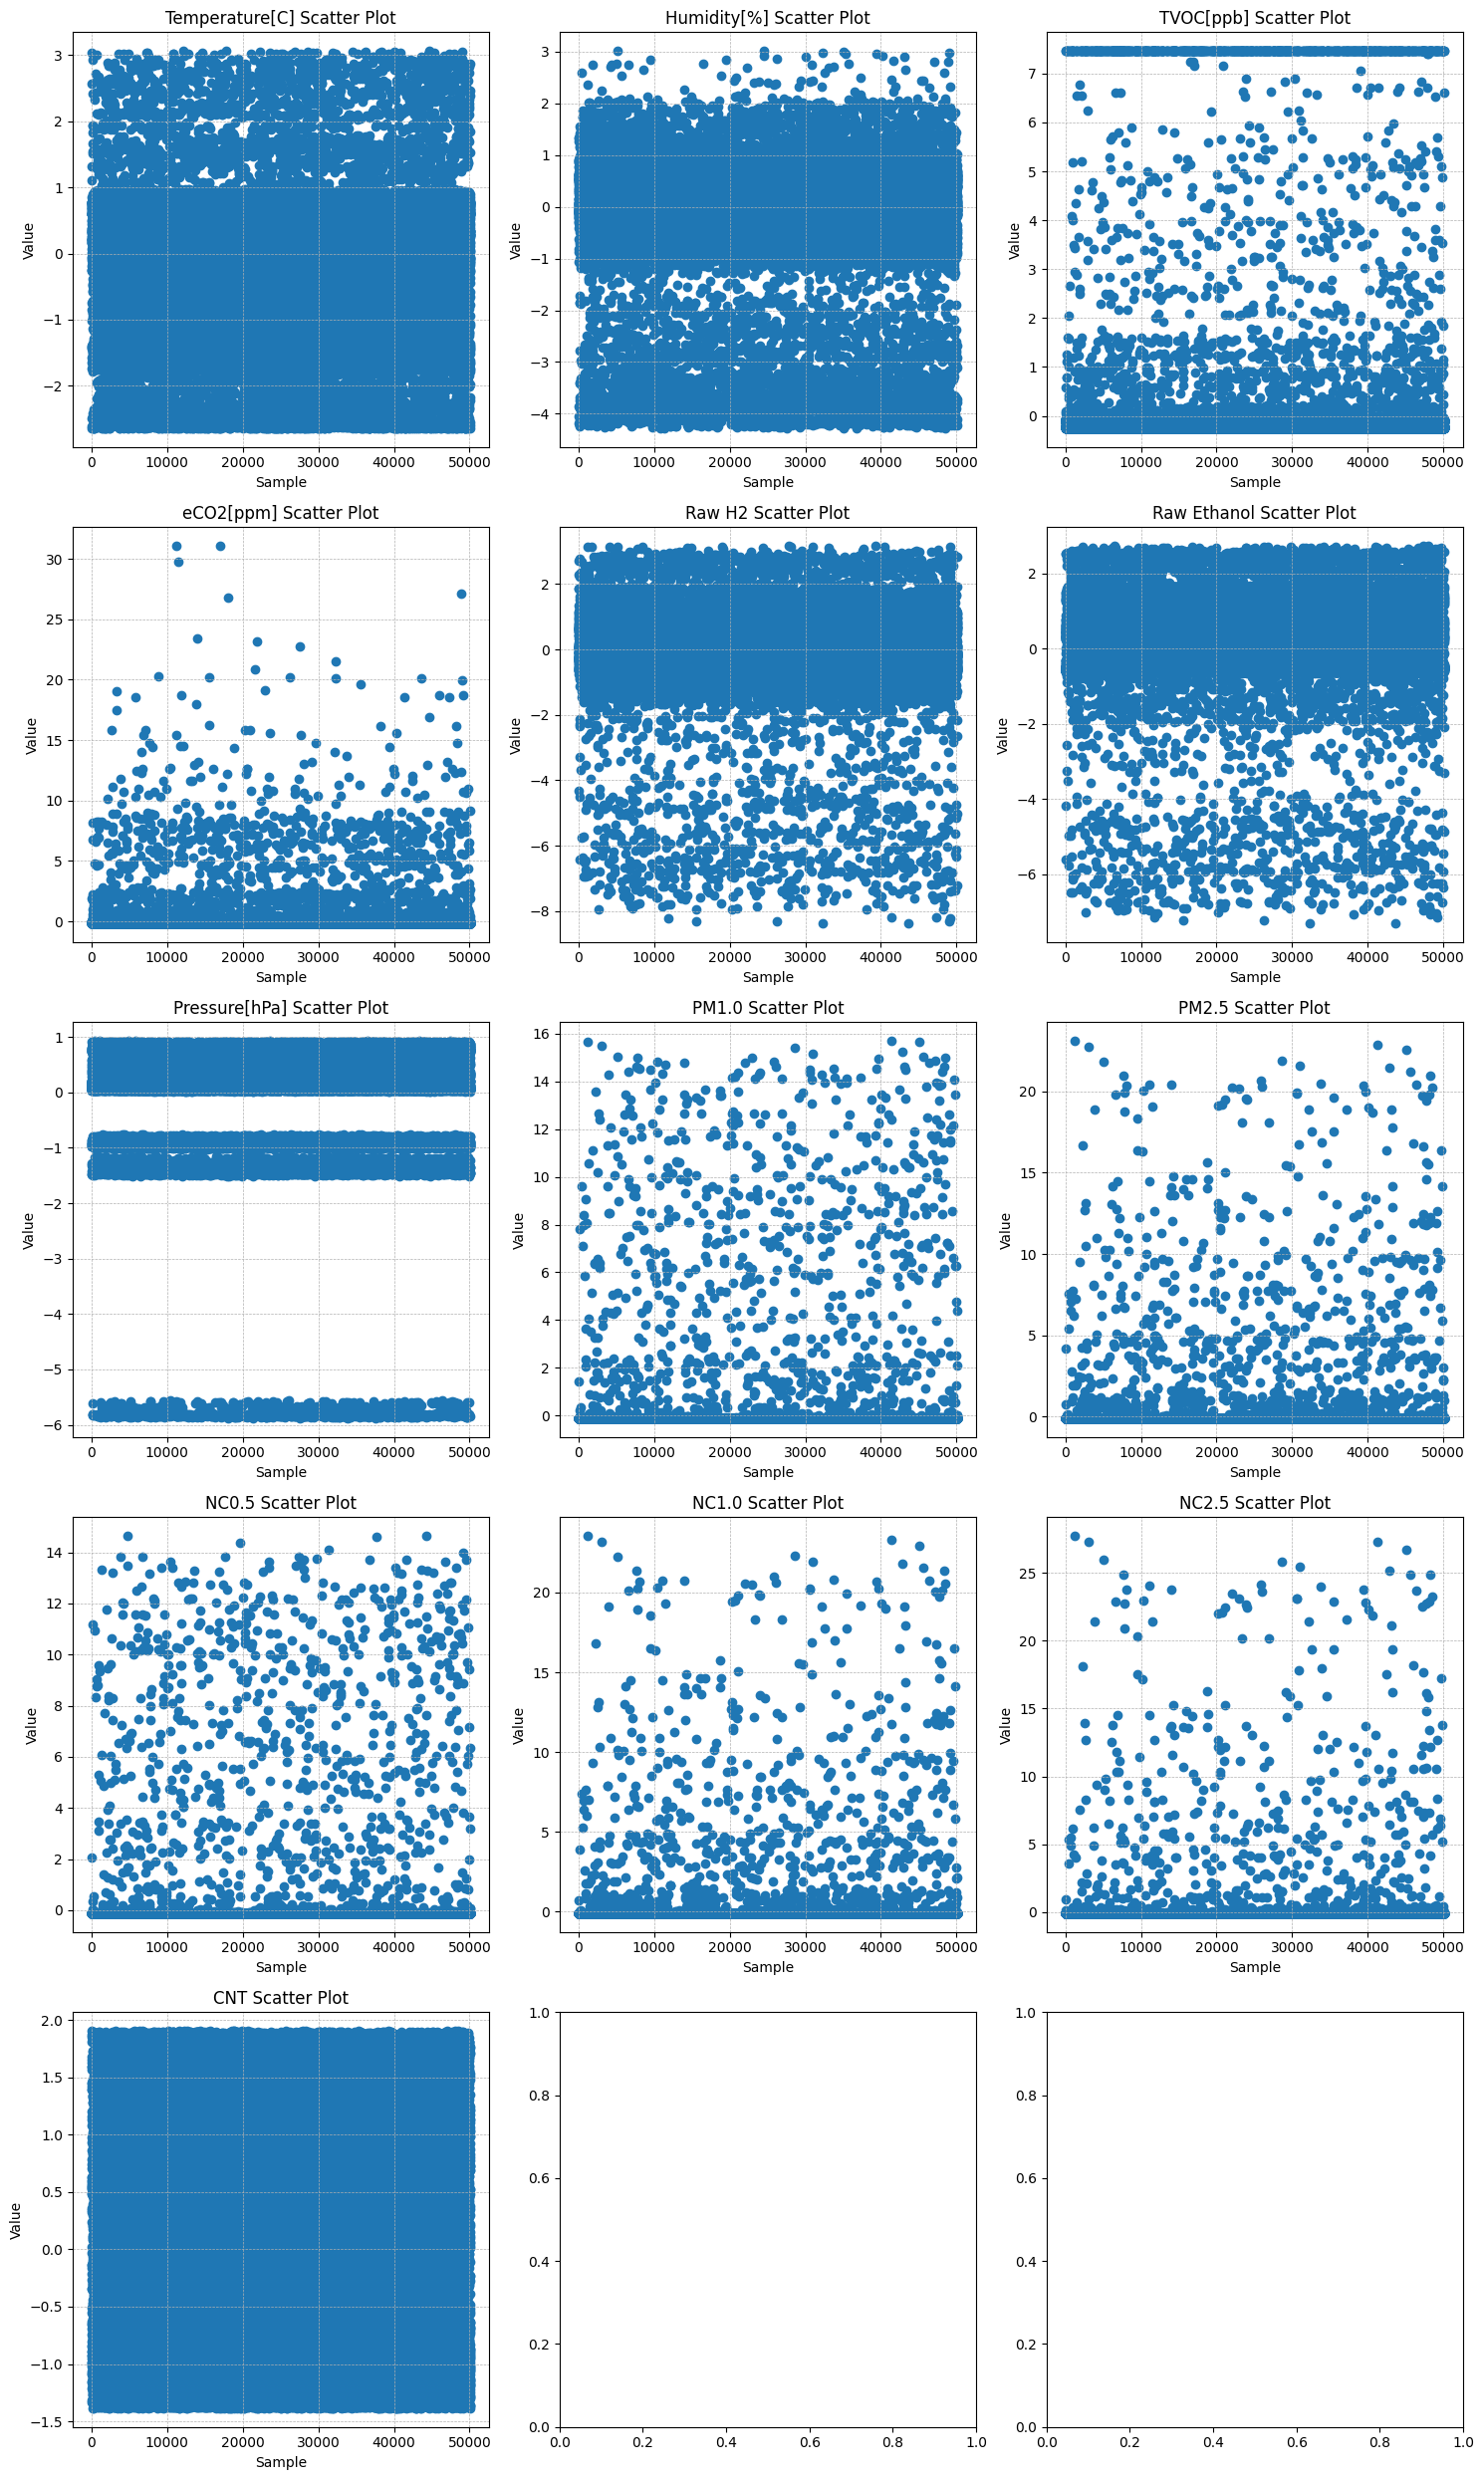

In [33]:
plot_feature_scatterplots(X_train, n_cols=3)

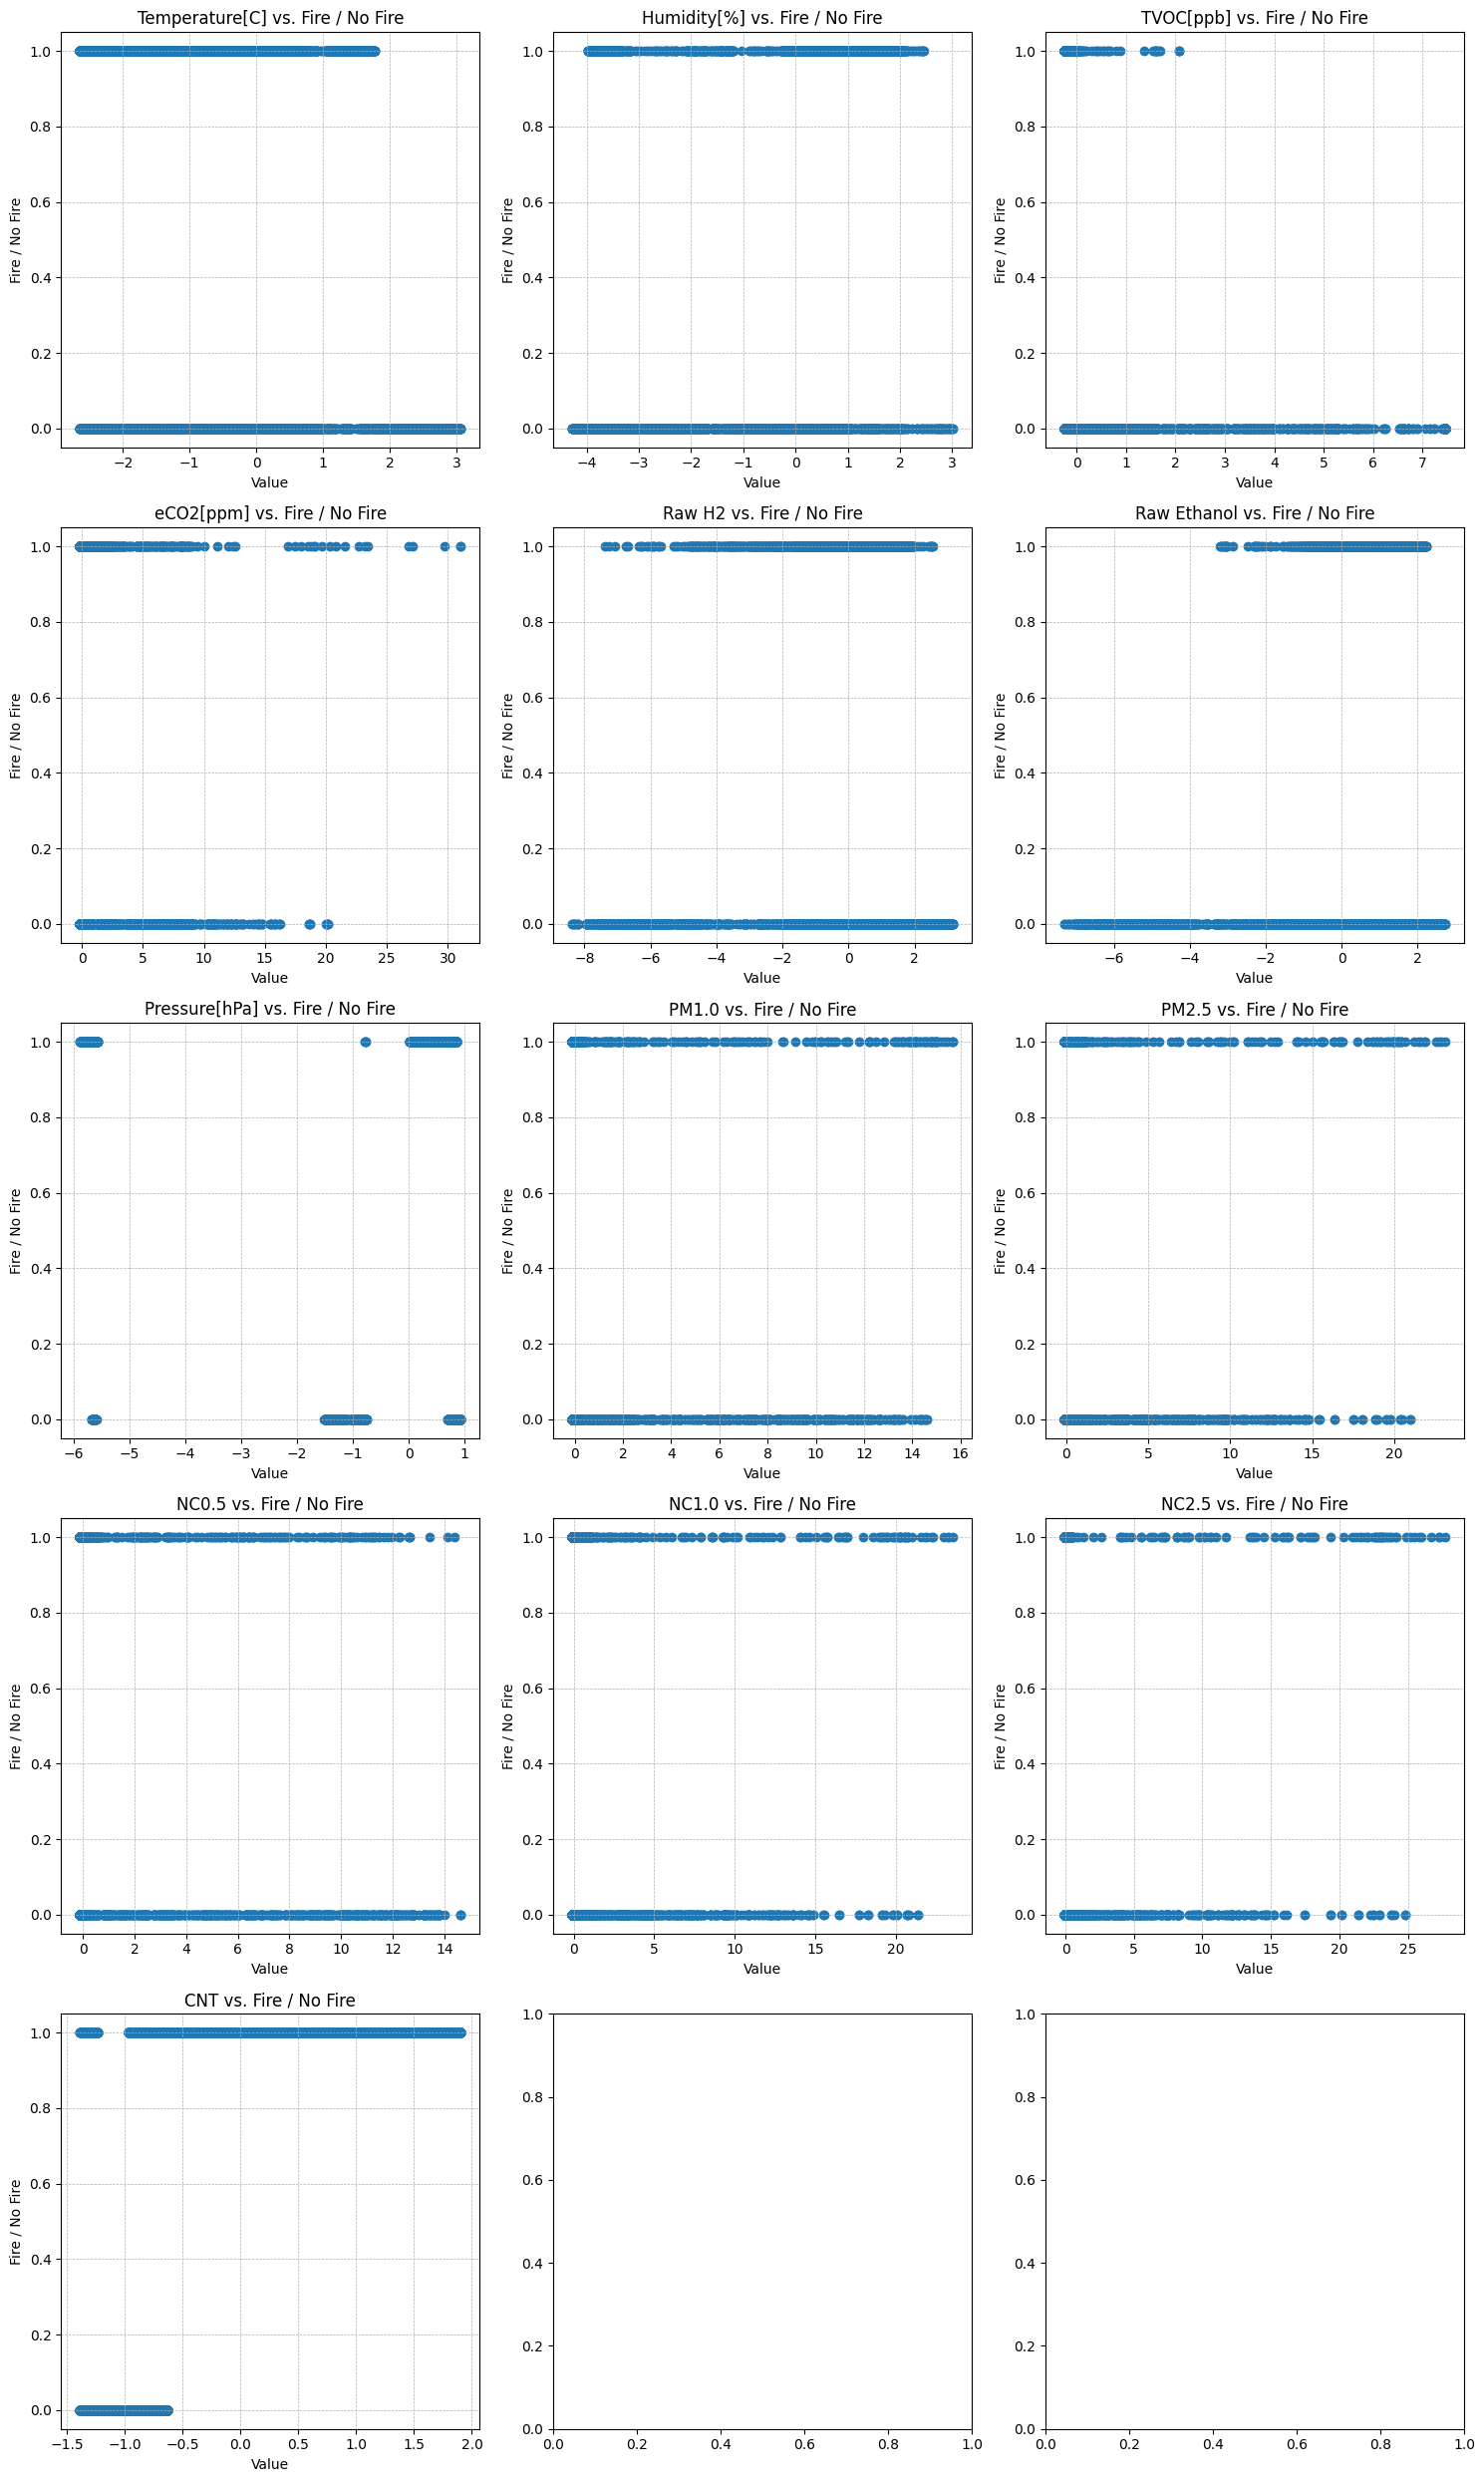

In [34]:
plot_feature_vs_fire(X_train, y_train, n_cols=3)

In [35]:
X_train = X_train.to_numpy()
X_test = X_test.to_numpy()
y_train = y_train.to_numpy()
y_test = y_test.to_numpy()

## Train

### Logistic Regression

In [37]:
logistic_regression = LogisticRegression(
    C=0.3,
    tol=0.0001,
    max_iter=1000,
    penalty='elasticnet',
    l1_ratio=.4,
    solver='saga',
    n_jobs=-2,
)
k=5
scores = cross_val_score(logistic_regression, X_train, y_train, cv=k, scoring="roc_auc")
print(f"Accuracy scores for the {k} folds: ", scores)
print(f"Mean accuracy: {np.mean(scores)}")
print(f"Standard deviation: {np.std(scores)}")

Accuracy scores for the 5 folds:  [0.99817707 0.99811051 0.99789007 0.99816603 0.99799512]
Mean accuracy: 0.9980677608729241
Standard deviation: 0.00010980371508358694


In [39]:
logistic_regression.fit(X_train, y_train)
y_pred = logistic_regression.predict_proba(X_test)[:, 1]
roc_auc = roc_auc_score(y_test, y_pred)
print(f"Test ROC AUC score: {roc_auc}")

Test ROC AUC score: 0.9983208940810692


### SVM

### Two-Layer NN

### CatBoost